# Exploring the "Adverse Weather Scenarios for Future Electricity Systems" dataset, as part of the CIReN project.

## Petros Zantis
## May - July 2023

<font size="4">

* In this notebook, the user can select a specific event of choice from the dataset, and visualise the **wind speed**, **surface temperature** and **solar radiation** over the entire map
    
    
* In addition, the user can create an animation to observe the event happen dynamically, or select a specific location of interest in the map and see the measured quantities as a **time series** or a **histogram**
    
    
* Finally, the *WindTurbine* class is demonstrated, which allows the user to convert wind speed data to power generation data

</font>


In [24]:
import os, glob
import numpy as np
import matplotlib.pyplot as plt
from myClasses import *

from netCDF4 import Dataset
from IPython.display import HTML
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display

%matplotlib inline

In [25]:
'''Data repository from CEDA'''

#dataset_loc = '.\\dap.ceda.ac.uk\\badc\\deposited2021\\adverse_met_scenarios_electricity\\data\\long_duration'

''' *** Change this string to your local dataset folder location *** '''

dataset_loc = 'C:\\Users\\pz61\\Box\\CIReN_Shared\\Task 2a - climate impacts\\Data'

# Details of the event of interest
event_type = [ 'summer_wind_drought', 'winter_wind_drought', 'summer_surplus_generation']
location = ['europe', 'uk']
extremity = ['return_period_1_in_2_years', 'return_period_1_in_5_years', 'return_period_1_in_10_years', 
 'return_period_1_in_20_years', 'return_period_1_in_50_years', 'return_period_1_in_100_years' , 'most_extreme_events']
duration_severity = ['duration' , 'severity']
global_warming_level = ['gwl4degC', 'gwl3degC', 'gwl12-4degC', 'gwl12-2degC', '*']
event_no = ['event1', 'event2', 'event3', '*']

def select_events(event_type, location, extremity, duration_severity, global_warming_level, event_no):
    '''A function to interactively select the event of interest from the complete database'''
    
    file_str = dataset_loc
    details = [event_type, location, extremity, duration_severity, global_warming_level, event_no]
    for det in details:
        file_str = os.path.join(file_str, det).replace(os.sep, '\\')
    print("\nThe selected event is: {}".format(file_str))
    return os.path.join(file_str, '*.nc').replace(os.sep, '\\')

interactive_plot = interactive(select_events, event_type=event_type, location=location, extremity=extremity, 
                              duration_severity=duration_severity, 
                               global_warming_level=global_warming_level, event_no=event_no )
interactive_plot

interactive(children=(Dropdown(description='event_type', options=('summer_wind_drought', 'winter_wind_drought'…

In [26]:
file_str = interactive_plot.result

print(file_str)

C:\Users\pz61\Box\CIReN_Shared\Task 2a - climate impacts\Data\summer_wind_drought\europe\return_period_1_in_2_years\duration\gwl4degC\event1\*.nc


In [27]:
Event_list = []

def create_events(file_str):
    '''A function to create Event instances for the imported events and add them in the Event_list 
        (just 1 in the case of this demonstrator notebook)

        file_str (str) : the desired event file location
    '''
    
    print("Creating event:")
    Event_list = []
    try:
        filelist = glob.glob(file_str)
        
        for file in filelist:
            details = file.split('\\')[7:-1]   
            print(*details)

            if len(Event_list)==0 or [*Event_list[-1].get_event_details().values()] != details:
           
                Event_list.append(Event(*details))
            else:
                print("Not added again, it's the same event!")
                
    except IndexError as i: # or FileNotFoundError as f: 
        print(str(i))
        print("The file you asked for does not exist. Try checking the directory.")
               
    return Event_list
        
Events_list = create_events(file_str)

Creating event:
summer_wind_drought europe return_period_1_in_2_years duration gwl4degC event1
summer_wind_drought europe return_period_1_in_2_years duration gwl4degC event1
Not added again, it's the same event!
summer_wind_drought europe return_period_1_in_2_years duration gwl4degC event1
Not added again, it's the same event!


In [28]:
def open_files(event_list, print_checks = True):
    '''A function to open the datasets from the .nc files and extract the quantities of interest, 
        and creates WeatherVariable instances to store the data and their details

        event_list (list of Events) : the list of Event instances created with create_events()
        print_checks (Bool) : a boolean to set if detailed checks are to be printed
    '''
        
    for event in event_list:
        details = event.get_event_details()
        file_str = dataset_loc
        for det in details:
            file_str = os.path.join(file_str, details[det]).replace(os.sep, '\\')
        file_str = os.path.join(file_str, '*.nc').replace(os.sep, '\\')
        
        try:
            filelist = glob.glob(file_str)
            data_lists = {}
            
            for file in filelist:
                
                dataset = Dataset(file ,mode='r')          
                var_str = list(dataset.variables.keys())[-1]

                lons = dataset.variables['longitude'][:]
                lats = dataset.variables['latitude'][:]
                gridded_lons, gridded_lats = np.meshgrid(lons,lats)

                time = dataset.variables['time'][:]
                variable = dataset.variables[var_str][:]  # data in shape [time,lat,lon]

                dataset.close()
                
                data_lists[var_str] = gridded_lons, gridded_lats, lons, lats, variable, time
                
                if print_checks:
                    # see the file inputs and netcdf dictionary keys to load:
                    print(file)
                    print("\nThe chosen file contains: {}".format(dataset.variables.keys()))
                    print("Longitude array shape: {}".format(lons.shape))
                    print("Latitude array shape: {}".format(lats.shape))
                    print("Time array shape: {}".format(time.shape))
                    print("Complete {} array shape: {}".format(var_str, variable.shape))

                    print("Minimum {} in data: {}".format(var_str, variable.min()))
                    print("Maximum {} in data: {}".format(var_str, variable.max()))
                    print()
                
            Wind = WeatherVariable('wind_speed', '100m Wind Speed', '(ms$^{-1}$)', plt.cm.RdBu_r, 'royalblue' )
            Temp = WeatherVariable('t2m', 'Surface Temperature', '($^{o}C$)', plt.cm.RdYlBu_r, 'darkorange' )
            Ssr = WeatherVariable('ssr', 'Net Surface Solar Radiation', '(W$s^{-2}$)', plt.cm.viridis, 'firebrick' )
            
            Wind.set_data(*data_lists[Wind.var])
            Temp.set_data(*data_lists[Temp.var])
            Temp.convert_to_C() 
            Ssr.set_data(*data_lists[Ssr.var])
            
            event.add_weather_variable(Wind)
            event.add_weather_variable(Temp)
            event.add_weather_variable(Ssr)
            
        except IndexError or FileNotFoundError: 
            print("The file you asked for does not exist. Try checking the directory.")
        
open_files(Events_list)

C:\Users\pz61\Box\CIReN_Shared\Task 2a - climate impacts\Data\summer_wind_drought\europe\return_period_1_in_2_years\duration\gwl4degC\event1\summer_wind_drought_europe_return_period_1_in_2_years_duration_gwl4degC_event1_ssr.nc

The chosen file contains: dict_keys(['longitude', 'latitude', 'time', 'ssr'])
Longitude array shape: (85,)
Latitude array shape: (81,)
Time array shape: (365,)
Complete ssr array shape: (365, 81, 85)
Minimum ssr in data: 0.0
Maximum ssr in data: 434.86644256726623

C:\Users\pz61\Box\CIReN_Shared\Task 2a - climate impacts\Data\summer_wind_drought\europe\return_period_1_in_2_years\duration\gwl4degC\event1\summer_wind_drought_europe_return_period_1_in_2_years_duration_gwl4degC_event1_tas.nc

The chosen file contains: dict_keys(['longitude', 'latitude', 'time', 't2m'])
Longitude array shape: (85,)
Latitude array shape: (81,)
Time array shape: (365,)
Complete t2m array shape: (365, 81, 85)
Minimum t2m in data: 229.5581038107897
Maximum t2m in data: 314.7055164625229


### Select the weather variable of interest to view a snapshot of it on the map. 
### Frame represents the chosen day of the year for the snapshot

In [29]:

def select_var(weather_var_name, frame):    
    for event in Events_list:
        title = event.get_event_details()
        #print(type(title.keys()))
        title = "{}, {}\n{}\n {}, {}, {}".format(*title.values())
        for weather_var in event.weather_vars:
            if weather_var.name == weather_var_name:
                weather_var.view_snapshot(title, frame)

interactive_plot = interactive(select_var, weather_var_name=['Surface Temperature','100m Wind Speed', 'Net Surface Solar Radiation'],
                              frame = widgets.IntSlider(min=0, max=364, step=1, value=50, continuous_update=True))
interactive_plot

interactive(children=(Dropdown(description='weather_var_name', options=('Surface Temperature', '100m Wind Spee…

### Select the weather variable of interest to view an animation of it on the map
### Frames represents the duration of the animation in days - careful of loading times!

In [30]:

%matplotlib notebook

plt.rcParams['animation.embed_limit'] = 2**128

def select_var(weather_var_name, frames):    
    for event in Events_list:
        title = event.get_event_details()
        #print(type(title.keys()))
        title = "{}, {}\n{}\n {}, {}, {}".format(*title.values())
        for weather_var in event.weather_vars:
            if weather_var.name == weather_var_name:
                anim = weather_var.view_animation(title, frames = frames)
                return anim

interactive_plot = interactive(select_var, weather_var_name=['Surface Temperature','100m Wind Speed', 'Net Surface Solar Radiation'],
                              frames = widgets.IntSlider(min=5, max=364, step=1, value=50, continuous_update=False))
interactive_plot


interactive(children=(Dropdown(description='weather_var_name', options=('Surface Temperature', '100m Wind Spee…

In [ ]:
'''The same animation but with controls (e.g. speed, pause etc.)'''

anim = interactive_plot.result
HTML(anim.to_jshtml())

### Interactively choose the desired latitude and longitude to view the wind speed time series and histogram for the specified location
### One can also choose whether to use thresholds, and choose their values accordingly


In [32]:
%matplotlib inline

Wind = Events_list[0].weather_vars[0]
title = Events_list[0].get_event_details()
title = "{}, {}\n{}\n {}, {}, {}".format(*title.values())

min_wind = widgets.FloatSlider(min=0, max=10, step=0.5, value=3, continuous_update=False)
max_wind = widgets.FloatSlider(min=11, max=30, step=0.5, value=17, continuous_update=False)

interactive_plot = interactive(Wind.set_thresholds, min_t=min_wind, max_t=max_wind )

display(interactive_plot)

lats, lons = Wind.lats, Wind.lons

Latitude = widgets.FloatSlider(min=min(lats), max=max(lats), step=np.abs(lats[1]-lats[0]), value=lats[10], continuous_update=False)
Longitude = widgets.FloatSlider(min=min(lons), max=max(lons), step=np.abs(lons[1]-lons[0]), value=lons[10], continuous_update=False)

interactive_plot = interactive(Wind.time_series, latitude=Latitude, longitude=Longitude, title=fixed(title))

# output = interactive_plot.result[-1]
interactive_plot

interactive(children=(FloatSlider(value=3.0, continuous_update=False, description='min_t', max=10.0, step=0.5)…

interactive(children=(FloatSlider(value=38.88890075683594, continuous_update=False, description='latitude', ma…

In [33]:
interactive_plot = interactive(Wind.histogram, latitude=Latitude, longitude=Longitude, title=fixed(title),
                              bins = widgets.IntSlider(min=5, max=40, step=1, value=20, continuous_update=False) )

interactive_plot

interactive(children=(FloatSlider(value=38.88890075683594, continuous_update=False, description='latitude', ma…

### Demonstration of the WindTurbine class, which allows the user to create wind turbines with the desired specs (cut-in, cut-out and rated speeds, rated power output)


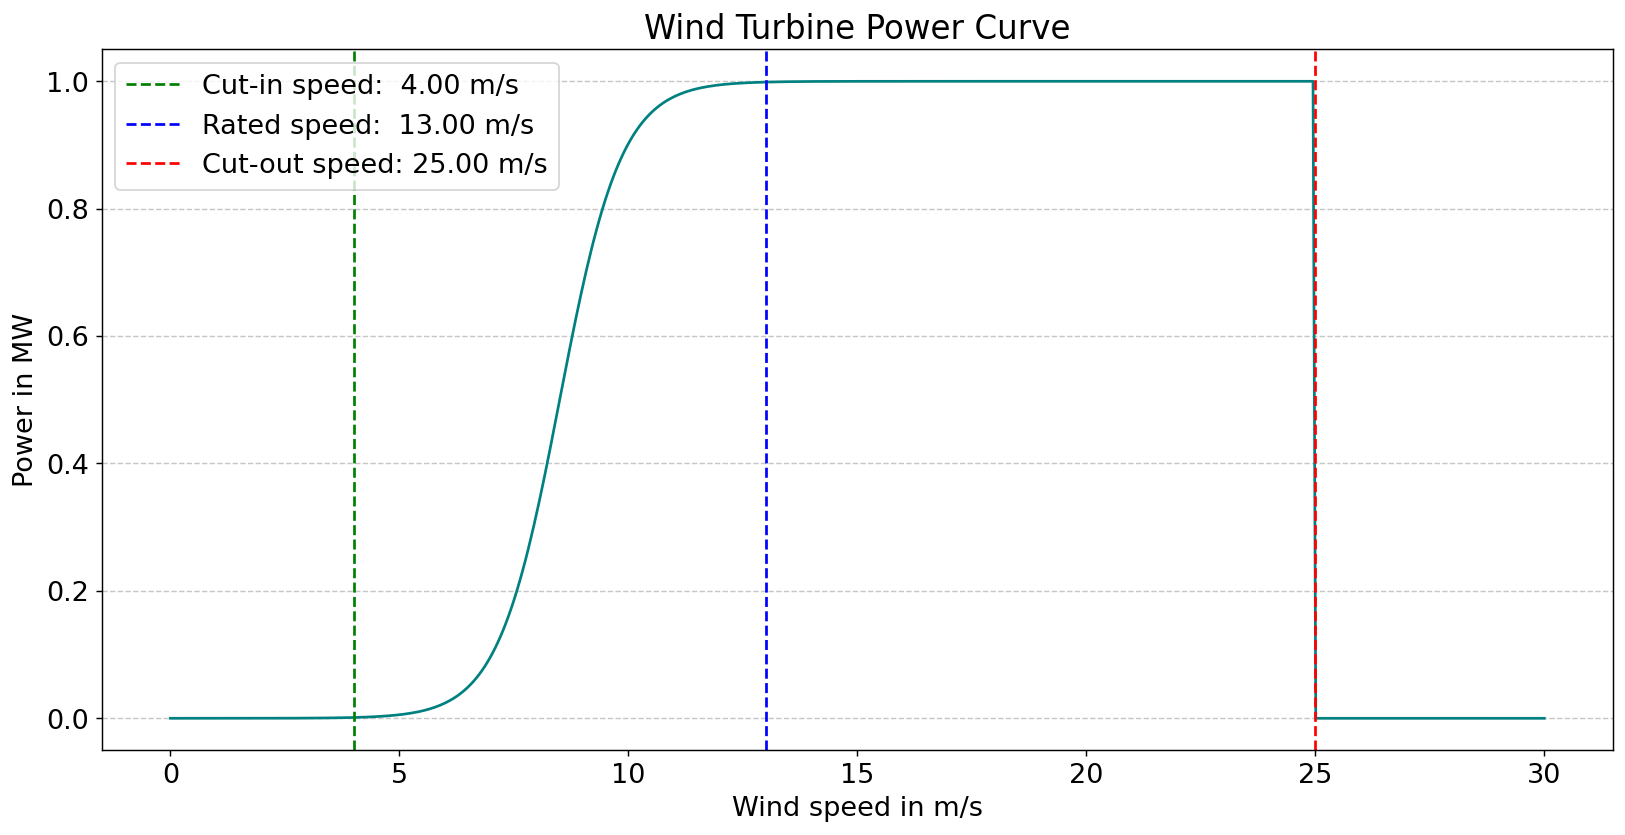

The closest location is (Lat: 50.55555725097656, Lon: 17.5)

100m Wind Speed above max threshold of 13.00 m/s:

100m Wind Speed: 13.128 m/s on 2006-11-01
100m Wind Speed: 14.275 m/s on 2006-12-05
Total high day counts: 2

100m Wind Speed below min threshold of 4.00 m/s:

100m Wind Speed: 2.685 m/s on 2006-01-31
100m Wind Speed: 3.526 m/s on 2006-02-03
100m Wind Speed: 3.976 m/s on 2006-02-07
100m Wind Speed: 3.779 m/s on 2006-02-10
100m Wind Speed: 3.256 m/s on 2006-02-11
100m Wind Speed: 3.919 m/s on 2006-02-14
100m Wind Speed: 3.282 m/s on 2006-02-18
100m Wind Speed: 2.329 m/s on 2006-02-19
100m Wind Speed: 3.829 m/s on 2006-02-23
100m Wind Speed: 3.633 m/s on 2006-03-13
100m Wind Speed: 2.244 m/s on 2006-04-05
100m Wind Speed: 3.529 m/s on 2006-04-10
100m Wind Speed: 3.694 m/s on 2006-04-26
100m Wind Speed: 3.198 m/s on 2006-05-04
100m Wind Speed: 3.989 m/s on 2006-05-05
100m Wind Speed: 3.749 m/s on 2006-05-09
100m Wind Speed: 3.874 m/s on 2006-05-11
100m Wind Speed: 3.593 m/s on 2

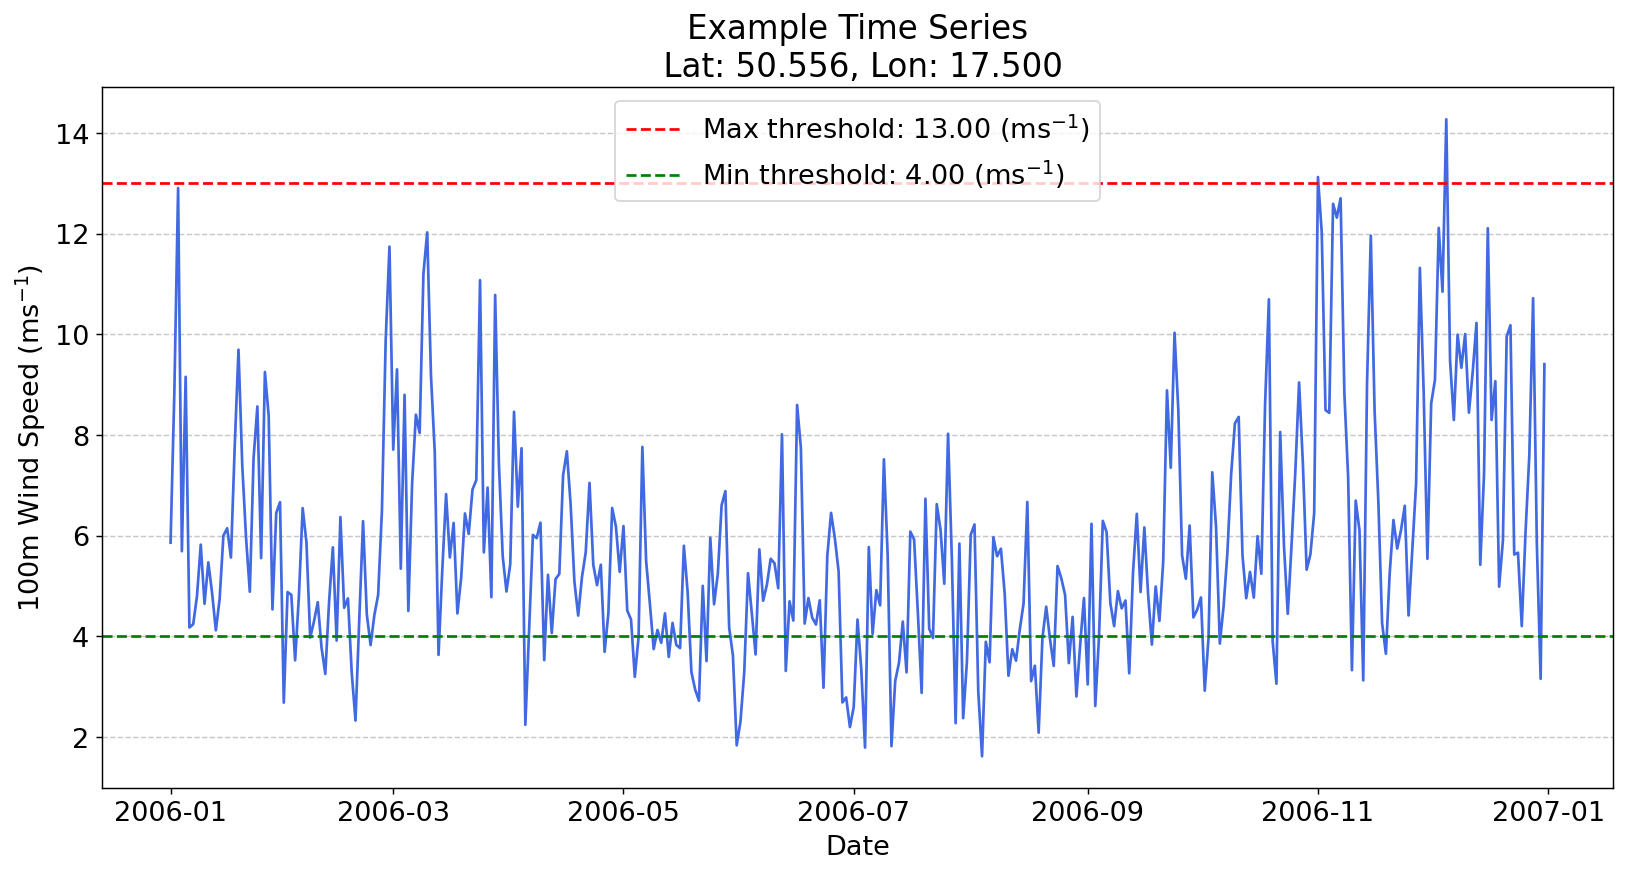

The closest location is (Lat: 50.55555725097656, Lon: 17.5)


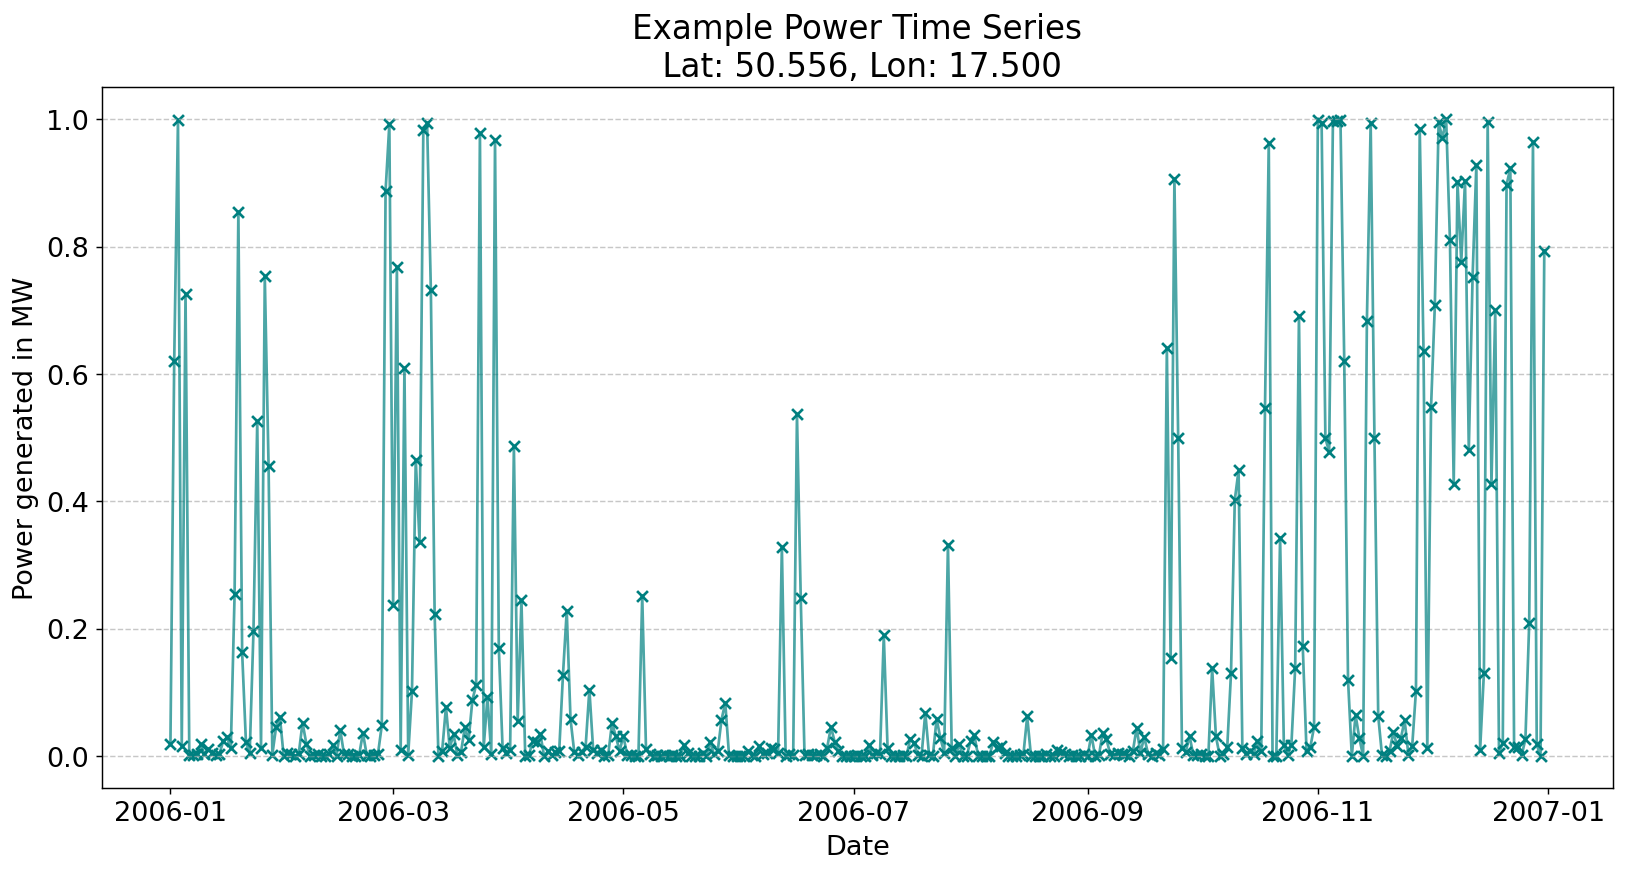

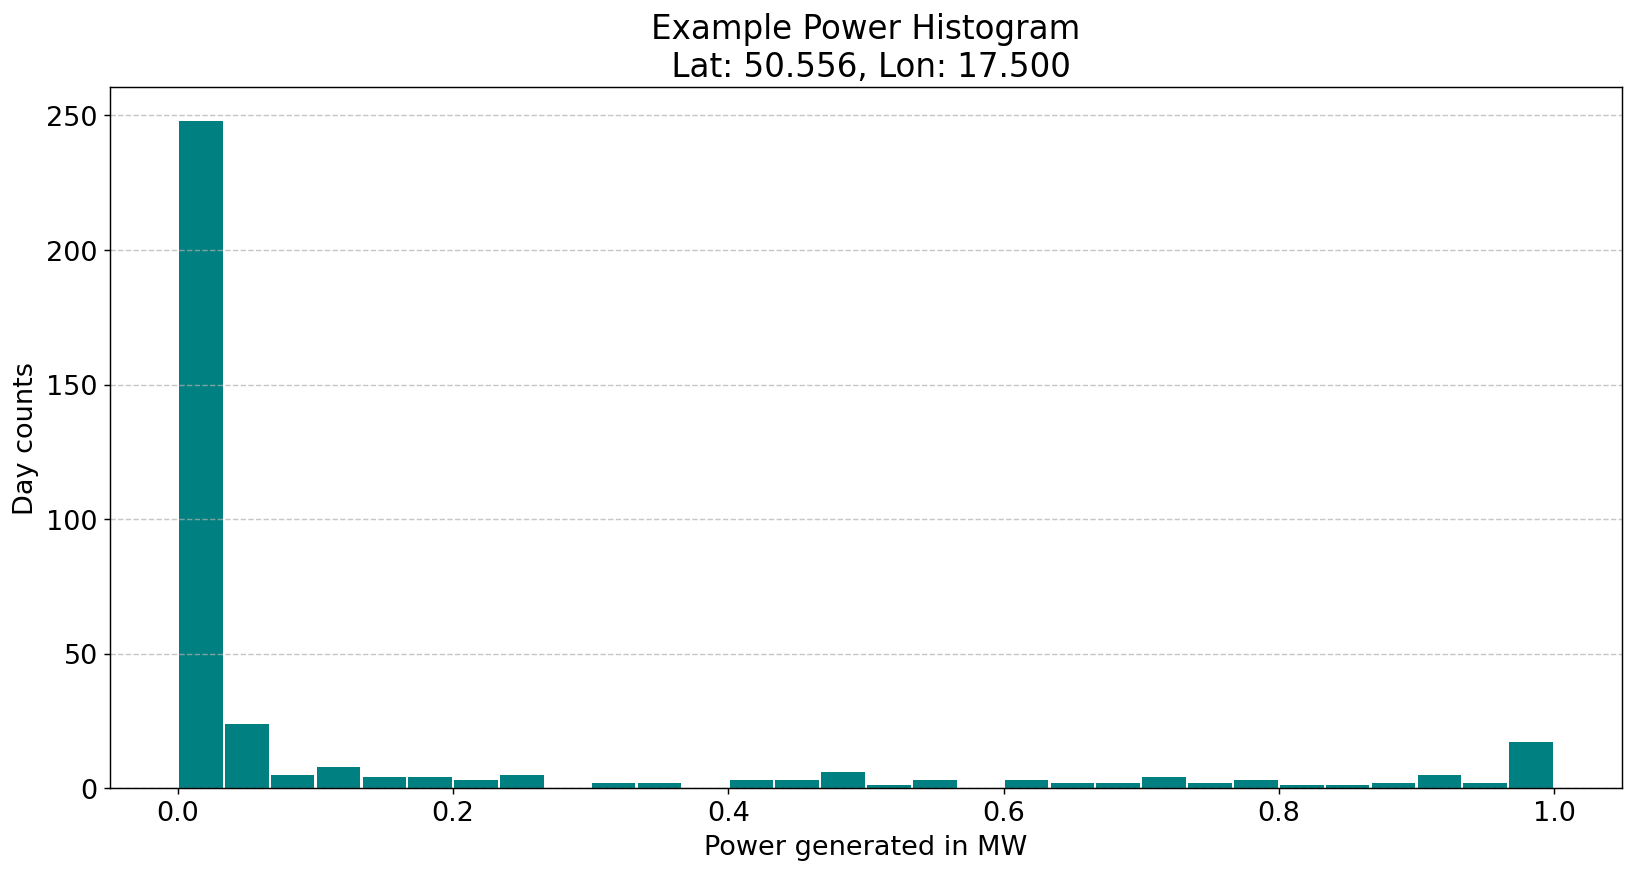

In [34]:
wt = WindTurbine()
wt.power_curve()

Wind.set_thresholds(4,13)

lat, lon = 50.55 , 17.5
Wind.time_series(lat, lon, thresholds=True)

date_conv, var_data, lat, lon = Wind.get_var_time_data(lat, lon)

wt.power_time_series(date_conv, var_data, lat, lon)
wt.power_histogram(var_data, lat, lon, bins=30)

### Interactively choose the desired latitude and longitude to view the surface temperature time series and histogram for the specified location
### One can also choose whether to use thresholds, and choose their values accordingly


In [35]:
Temp = Events_list[0].weather_vars[1]
title = Events_list[0].get_event_details()
title = "{}, {}\n{}\n {}, {}, {}".format(*title.values())

min_temp = widgets.FloatSlider(min=5, max=15, step=0.5, value=10, continuous_update=False)
max_temp = widgets.FloatSlider(min=25, max=35, step=0.5, value=25, continuous_update=False)

interactive_plot = interactive(Temp.set_thresholds, min_t=min_temp, max_t=max_temp )

display(interactive_plot)

lats, lons = Temp.lats, Temp.lons

Latitude = widgets.FloatSlider(min=min(lats), max=max(lats), step=np.abs(lats[1]-lats[0]), value=lats[10], continuous_update=False)
Longitude = widgets.FloatSlider(min=min(lons), max=max(lons), step=np.abs(lons[1]-lons[0]), value=lons[10], continuous_update=False)

interactive_plot = interactive(Temp.time_series, latitude=Latitude, longitude=Longitude, title=fixed(title))

interactive_plot

interactive(children=(FloatSlider(value=10.0, continuous_update=False, description='min_t', max=15.0, min=5.0,…

interactive(children=(FloatSlider(value=35.555564880371094, continuous_update=False, description='latitude', m…

In [36]:
interactive_plot = interactive(Temp.histogram, latitude=Latitude, longitude=Longitude, title=fixed(title),
                              bins = widgets.IntSlider(min=5, max=40, step=1, value=20, continuous_update=False) )

interactive_plot

interactive(children=(FloatSlider(value=35.555564880371094, continuous_update=False, description='latitude', m…

### Interactively choose the desired latitude and longitude to view the net surface solar radiation time series and histogram for the specified location

In [37]:
Ssr = Events_list[0].weather_vars[2]
title = Events_list[0].get_event_details()
title = "{}, {}\n{}\n {}, {}, {}".format(*title.values())

lats, lons = Ssr.lats, Ssr.lons

Latitude = widgets.FloatSlider(min=min(lats), max=max(lats), step=np.abs(lats[1]-lats[0]), value=50, continuous_update=False)
Longitude = widgets.FloatSlider(min=min(lons), max=max(lons), step=np.abs(lons[1]-lons[0]), value=0, continuous_update=False)

interactive_plot = interactive(Ssr.time_series, latitude=Latitude, longitude=Longitude, title=fixed(title), thresholds=fixed(False))

interactive_plot

interactive(children=(FloatSlider(value=50.0, continuous_update=False, description='latitude', max=74.44445800…

In [ ]:
interactive_plot = interactive(Ssr.histogram, latitude=Latitude, longitude=Longitude, title=fixed(title),
                              bins = widgets.IntSlider(min=5, max=40, step=1, value=20, continuous_update=False), thresholds=fixed(False))

interactive_plot